In [2]:
import torch

from collections.abc import Iterable

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

import glob
import re

In [3]:
#for matplotlib plots
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [4]:
def running_mse(prediction, actual):
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return mse

def get_metrics(actual_preys, actual_predators, pred_preys, pred_predators):
    metrics = []
    for actual_prey, actual_predator, pred_prey, pred_predator in zip(actual_preys, actual_predators, pred_preys, pred_predators):
        mse_prey = mean_squared_error(actual_prey[80:], pred_prey[80:])
        mse_predator = mean_squared_error(actual_predator[80:], pred_predator[80:])
        mae_prey = mean_absolute_error(actual_prey[80:], pred_prey[80:])
        mae_predator = mean_absolute_error(actual_predator[80:], pred_predator[80:])
        mape_prey = mean_absolute_percentage_error(actual_prey[80:], pred_prey[80:])
        mape_predator = mean_absolute_percentage_error(actual_predator[80:], pred_predator[80:])
        rmse_prey = root_mean_squared_error(actual_prey[80:], pred_prey[80:])
        rmse_predator = root_mean_squared_error(actual_predator[80:], pred_predator[80:])
        running_mse_prey = running_mse(pred_prey[80:], actual_prey[80:])
        running_mse_predator = running_mse(pred_predator[80:], actual_predator[80:])
        metrics.append((mse_prey, mse_predator, mae_prey, mae_predator, mape_prey, mape_predator, rmse_prey, rmse_predator, running_mse_prey, running_mse_predator))
    return metrics

def move_to_cpu(obj):
    """Recursively convert tensors to CPU NumPy arrays."""
    if isinstance(obj, torch.Tensor):
        # Move tensor to CPU and convert to NumPy
        return obj.detach().cpu().numpy()
    elif isinstance(obj, np.ndarray):
        # Already a NumPy array (no action needed)
        return obj
    elif isinstance(obj, dict):
        # Process dictionary values
        return {k: move_to_cpu(v) for k, v in obj.items()}
    elif isinstance(obj, Iterable) and not isinstance(obj, str):
        # Process lists, tuples, etc.
        return type(obj)(move_to_cpu(v) for v in obj)
    else:
        # Return Python primitives (int, float, etc.) as-is
        return obj

In [5]:
best_overall_params = {}

Key: (8, 5e-05):  0.7061096370220185
Key: (8, 1e-05):  1.046151393254598
Key: (4, 0.0001):  0.6860743419329325
Key: (4, 5e-05):  0.735856526295344
Key: (2, 0.0001):  0.7133804766337076
Key: (8, 0.0001):  0.6611025961240132
Key: (2, 5e-05):  0.7699060968557994
Key: (4, 1e-05):  2.1537112601598105
Key: (2, 1e-05):  2.9323235042889912

Best validation loss: 0.6611025961240132
Best file: (8, 0.0001)


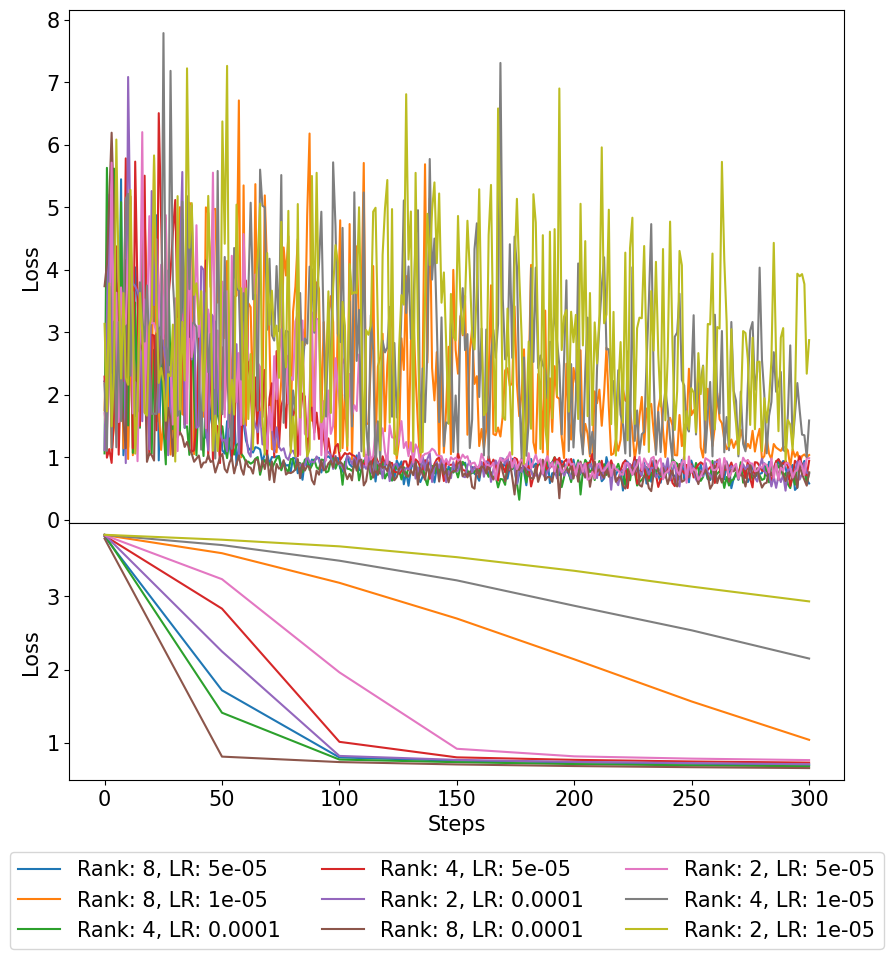

In [6]:
all_train_loss = []
all_val_loss = []
all_keys = []
best_val_losses = []

best_rank_lr_loss = 1000
best_rank_lr = None

pattern = r'grid_results_\d+_[\d.e+-]+\.pt'

result_files = glob.glob("../results/*")
result_files = [file for file in result_files if re.search(pattern, file)]

for file_path in result_files:
    # Load the joblib file
    result = torch.load(file_path, weights_only=False, map_location=torch.device('cpu'))
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    valloss = result[key]['val_losses'] 
    valloss.append([result[key]['final_val_loss'], 300])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(valloss)
    all_keys.append(key)
    best_val_losses.append(result[key]['final_val_loss'])
    
    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_rank_lr_loss:
        best_rank_lr_loss = result[key]['final_val_loss']
        best_rank_lr = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_rank_lr_loss}")
print(f"Best file: {best_rank_lr}")
print(f"{'='*50}")

best_overall_params['lora_rank'] = best_rank_lr[0]
best_overall_params['learning_rate'] = best_rank_lr[1]

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss) 
all_keys = np.array(all_keys)
keys_remapped = []
for key in all_keys:
    rank = int(key[0])
    lr = key[1]
    keys_remapped.append(f"Rank: {rank}, LR: {lr}")

fig, ax = plt.subplots(2, figsize=(10, 10), height_ratios=[1, 0.5])
for i in range(len(all_train_loss)):
    ax[0].plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{keys_remapped[i]}")
for i in range(len(all_val_loss)):
    ax[1].plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{keys_remapped[i]}")
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Steps')
for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
    ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
ax.legend(loc='lower left', bbox_to_anchor=(-0.09, -0.7), ncol=3, fontsize=SMALL_SIZE-5)
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/lora_lr_rank_loss.png', dpi=300, bbox_inches='tight')

['../results/grid_results_768.pt', '../results/grid_results_128.pt', '../results/grid_results_512.pt']
Key: 768:  0.6614443337917328
Key: 128:  0.8950828814506531
Key: 512:  0.6642499995231629

Best validation loss: 0.6614443337917328
Best file: 768


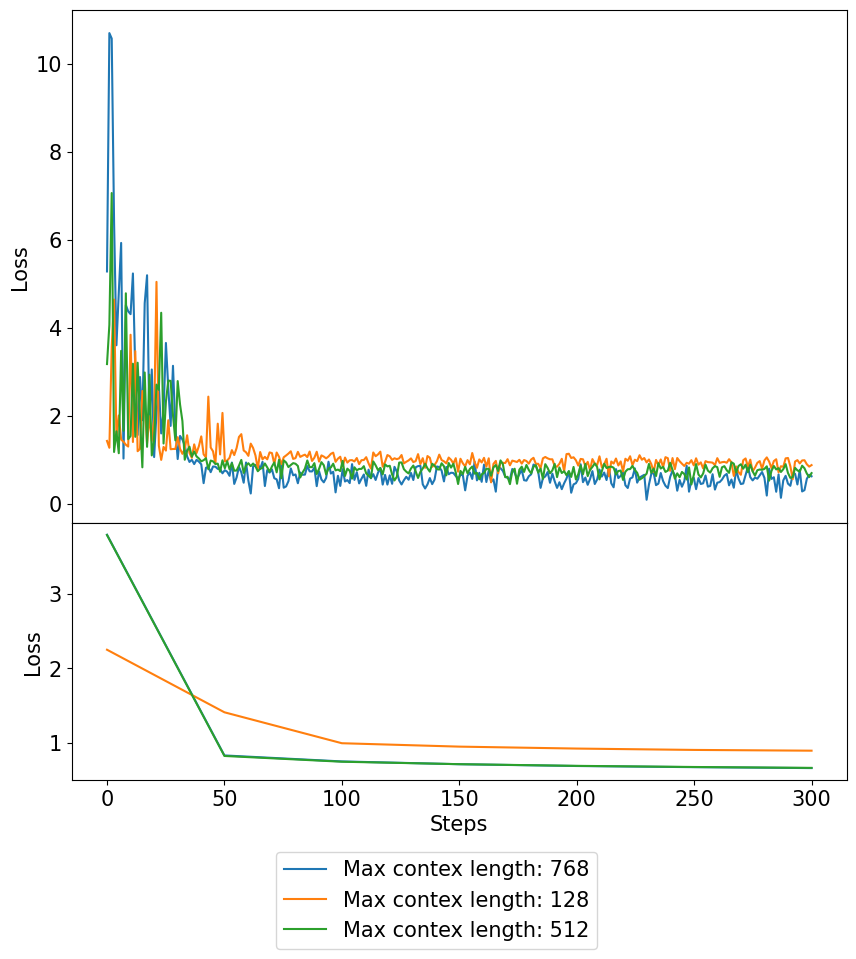

In [7]:
all_train_loss = []
all_val_loss = []
all_keys = []
best_val_losses = []

best_ctx_loss = 1000
best_ctx = None

# Pattern to match files of the form grid_results_NUMBER.joblib
pattern = r'grid_results_\d+\.pt'

# Get all files in the results directory
result_files = glob.glob('../results/*')

# Filter files that match the pattern (just one number after grid_results_)
result_files = [file for file in result_files if re.search(pattern, file)]

print(result_files)

# Display the content of each file
for file_path in result_files:
    # Load the joblib file
    result = torch.load(file_path, weights_only=False, map_location=torch.device('cpu'))
    
    key = next(iter(result.keys()))
    print(f"Key: {key}: ", result[key]['final_val_loss'])

    valloss = result[key]['val_losses'] 
    valloss.append([result[key]['final_val_loss'], 300])

    all_train_loss.append(result[key]['train_losses'])
    all_val_loss.append(valloss)
    all_keys.append(key)
    best_val_losses.append(result[key]['final_val_loss'])

    # Check if the current file has the best validation loss
    if result[key]['final_val_loss'] < best_ctx_loss:
        best_ctx_loss = result[key]['final_val_loss']
        best_ctx = key

print(f"\n{'='*50}")
print(f"Best validation loss: {best_ctx_loss}")
print(f"Best file: {best_ctx}")
print(f"{'='*50}")

best_overall_params['max_ctx_length'] = best_ctx

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)

all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss) 
all_keys = np.array(all_keys)
keys_remapped = []
for key in all_keys:
    ctx = int(key)
    keys_remapped.append(f"Max contex length: {key}")

fig, ax = plt.subplots(2, figsize=(10, 10), height_ratios=[1, 0.5])
for i in range(len(all_train_loss)):
    ax[0].plot(all_train_loss[i, :, 1], all_train_loss[i, :, 0], label=f"{keys_remapped[i]}")
for i in range(len(all_val_loss)):
    ax[1].plot(all_val_loss[i, :, 1], all_val_loss[i, :, 0], label=f"{keys_remapped[i]}")
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Steps')
for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=SMALL_SIZE-5)
    ax.set_ylabel(ax.get_ylabel(), fontsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE-5)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE-5)
ax.legend(loc='lower left', bbox_to_anchor=(0.25, -0.7), fontsize=SMALL_SIZE-5)
plt.subplots_adjust(hspace=0)
plt.savefig('../plots/lora_ctx_loss.png', dpi=300, bbox_inches='tight')